In [ ]:
#TASK3---------

Optimal Number of Clusters: 2 with DB Index: 0.742


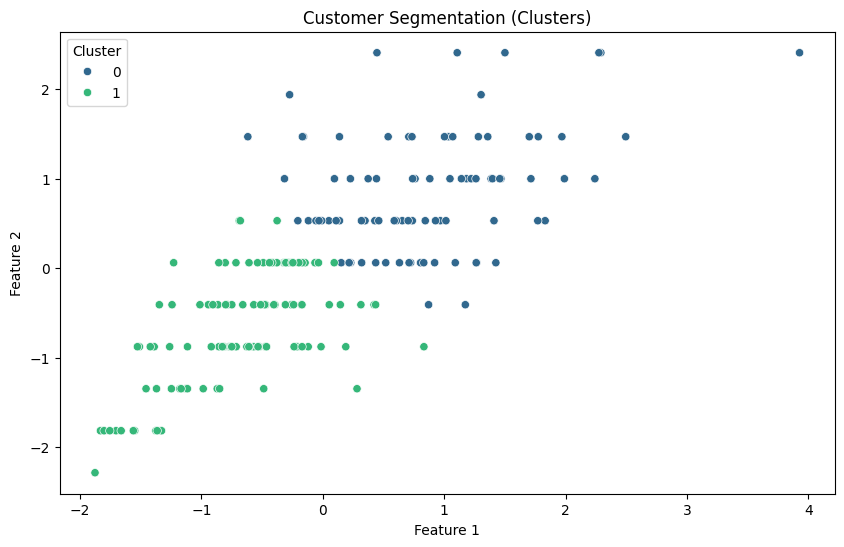

Davies-Bouldin Index for each number of clusters:
   Number of Clusters  DB Index
0                   2  0.741619
1                   3  0.791922
2                   4  0.899466
3                   5  0.963579
4                   6  0.890386
5                   7  0.832653
6                   8  0.853937
7                   9  0.907876
8                  10  0.901683

Final customer segmentation saved to 'Segmented_Customers.csv'


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Preprocess and merge data
# Aggregate transaction data by customer
customer_transactions = transactions_df.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spending
    "ProductID": "nunique"  # Number of unique products purchased
}).reset_index()

# Merge customer profiles with transaction data
customer_data = pd.merge(customers_df, customer_transactions, on="CustomerID", how="left")
customer_data.fillna(0, inplace=True)  # Fill missing values with 0

# Encode categorical variables (Region)
customer_data = pd.get_dummies(customer_data, columns=["Region"], drop_first=True)

# Select features for clustering
features = customer_data.drop(["CustomerID", "SignupDate"], axis=1, errors='ignore')

# Ensure only numeric features are used
features = features.select_dtypes(include=['number'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# --- Clustering ---
# Use KMeans clustering with a range of cluster numbers
cluster_metrics = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    cluster_metrics.append((n_clusters, db_index))

# Find the optimal number of clusters (lowest DB Index)
optimal_clusters = min(cluster_metrics, key=lambda x: x[1])
print(f"Optimal Number of Clusters: {optimal_clusters[0]} with DB Index: {optimal_clusters[1]:.3f}")

# Final clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters[0], random_state=42)
customer_data["Cluster"] = kmeans.fit_predict(scaled_features)

# --- Visualization ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=customer_data["Cluster"], palette="viridis")
plt.title("Customer Segmentation (Clusters)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Cluster")
plt.show()

# --- Report ---
# Save clustering metrics
metrics_df = pd.DataFrame(cluster_metrics, columns=["Number of Clusters", "DB Index"])
metrics_df.to_csv("Clustering_Metrics.csv", index=False)

# Save final customer data with cluster assignments
customer_data.to_csv("Segmented_Customers.csv", index=False)

# --- Summary ---
print("Davies-Bouldin Index for each number of clusters:")
print(metrics_df)
print("\nFinal customer segmentation saved to 'Segmented_Customers.csv'")